In [1]:
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import json
%matplotlib inline

pd.options.display.max_columns = 50
pd.options.display.max_colwidth = 300

## Predicting "Greenness" Of Content

This dataset comes from [stumbleupon](https://www.stumbleupon.com/), a web page recommender and was made available [here](https://www.kaggle.com/c/stumbleupon/download/train.tsv)

A description of the columns is below

FieldName|Type|Description
---------|----|-----------
url|string|Url of the webpage to be classified
urlid|integer| StumbleUpon's unique identifier for each url
boilerplate|json|Boilerplate text
alchemy_category|string|Alchemy category (per the publicly available Alchemy API found at www.alchemyapi.com)
alchemy_category_score|double|Alchemy category score (per the publicly available Alchemy API found at www.alchemyapi.com)
avglinksize| double|Average number of words in each link
commonLinkRatio_1|double|# of links sharing at least 1 word with 1 other links / # of links
commonLinkRatio_2|double|# of links sharing at least 1 word with 2 other links / # of links
commonLinkRatio_3|double|# of links sharing at least 1 word with 3 other links / # of links
commonLinkRatio_4|double|# of links sharing at least 1 word with 4 other links / # of links
compression_ratio|double|Compression achieved on this page via gzip (measure of redundancy)
embed_ratio|double|Count of number of <embed> usage
frameBased|integer (0 or 1)|A page is frame-based (1) if it has no body markup but have a frameset markup
frameTagRatio|double|Ratio of iframe markups over total number of markups
hasDomainLink|integer (0 or 1)|True (1) if it contains an <a> with an url with domain
html_ratio|double|Ratio of tags vs text in the page
image_ratio|double|Ratio of <img> tags vs text in the page
is_news|integer (0 or 1) | True (1) if StumbleUpon's news classifier determines that this webpage is news
lengthyLinkDomain| integer (0 or 1)|True (1) if at least 3 <a> 's text contains more than 30 alphanumeric characters
linkwordscore|double|Percentage of words on the page that are in hyperlink's text
news_front_page| integer (0 or 1)|True (1) if StumbleUpon's news classifier determines that this webpage is front-page news
non_markup_alphanum_characters|integer| Page's text's number of alphanumeric characters
numberOfLinks|integer Number of <a>|markups
numwords_in_url| double|Number of words in url
parametrizedLinkRatio|double|A link is parametrized if it's url contains parameters or has an attached onClick event
spelling_errors_ratio|double|Ratio of words not found in wiki (considered to be a spelling mistake)
label|integer (0 or 1)|User-determined label. Either evergreen (1) or non-evergreen (0); available for train.tsv only

### What are 'evergreen' sites?
- These are websites that always relevant like recipies or reviews (as opposed to current events)
- Look at some examples

In [2]:
data = pd.read_csv('./../../assets/datasets/train.csv', sep='\t', na_values='?')

In [3]:
# Feature Selection

In [4]:
data['news_front_page'].head()

0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: news_front_page, dtype: float64

In [40]:
data['news_front_page'].value_counts()
pd.isnull(data['news_front_page']).value_counts()

False    6147
True     1248
Name: news_front_page, dtype: int64

In [53]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7395 entries, 0 to 7394
Data columns (total 26 columns):
url                               7395 non-null object
urlid                             7395 non-null int64
boilerplate                       7395 non-null object
alchemy_category                  7395 non-null object
alchemy_category_score            7395 non-null object
avglinksize                       7395 non-null float64
commonlinkratio_1                 7395 non-null float64
commonlinkratio_2                 7395 non-null float64
commonlinkratio_3                 7395 non-null float64
commonlinkratio_4                 7395 non-null float64
compression_ratio                 7395 non-null float64
embed_ratio                       7395 non-null float64
framebased                        7395 non-null int64
frameTagRatio                     7395 non-null float64
hasDomainLink                     7395 non-null int64
html_ratio                        7395 non-null float64
image_r

In [5]:
## within alchemy_category, there was already a value for 'unknown', I chose to add nulls to this cat.
## the corrisponding score for 'unknown' was 0.400001, there for this was our fill value for the new unknowns
## is_news, consisted of 1.0 and null. I chose to fill null with 0 to represent false.
## there was no way to determine the catigory for the nulls in front page news. This column was dropped.

data['alchemy_category'].fillna(value='unknown', axis=None, inplace=True)
data['alchemy_category_score'].fillna(value='0.400001', axis=None, inplace=True)
data['is_news'].fillna(value=0, axis=None, inplace=True)
data.dropna(axis=1, how='any', inplace=True)

In [14]:
# Feature engineering to construct new features

from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression

# drop the words
# do dummies of the categoricals
# scale the numericals so we can look at ceofficients
X_norm = pd.get_dummies(data.drop(['label','url','urlid','boilerplate','alchemy_category'], axis = 1))
scaler = MinMaxScaler()
columns = X_norm.columns.values
X_norm = scaler.fit_transform(X_norm)
y = data['label']
# logit regression does regularization allows you to look at the coefficients with logit
logreg = LogisticRegression()
logreg.fit(X_norm,y)

coeffs = pd.DataFrame(logreg.coef_, columns = columns)
y_pred = logreg.predict(X_test)
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.83      0.74      0.78      1198
          1       0.77      0.85      0.81      1243

avg / total       0.80      0.80      0.80      2441



In [ ]:
# Train a logit model

In [10]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.grid_search import GridSearchCV
from sklearn.preprocessing import StandardScaler


from sklearn.cross_validation import train_test_split, cross_val_score
X_train, X_test, y_train, y_test = train_test_split(X_norm, y, test_size=0.33, random_state=42)

logreg = LogisticRegression()
C_vals = [0.0001, 0.001, 0.01, 0.1, 0.5, 0.75, 1.0, 2.5, 5.0, 10.0, 100.0, 1000.0]
penalties = ['l1','l2']

gs = GridSearchCV(logreg, {'penalty':penalties, 'C':C_vals}, verbose=True, cv=5, scoring='f1_macro')
gs.fit(X_train, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


/Users/work/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:   46.2s finished


GridSearchCV(cv=5, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'penalty': ['l1', 'l2'], 'C': [0.0001, 0.001, 0.01, 0.1, 0.5, 0.75, 1.0, 2.5, 5.0, 10.0, 100.0, 1000.0]},
       pre_dispatch='2*n_jobs', refit=True, scoring='f1_macro',
       verbose=True)

In [11]:
gs.best_params_

{'C': 10.0, 'penalty': 'l2'}

In [12]:
logreg = LogisticRegression(C=10.0, penalty='l2', solver='liblinear')
logreg.fit(X_train, y_train)

LogisticRegression(C=10.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [13]:
y_pred = logreg.predict(X_test)
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.64      0.52      0.57      1198
          1       0.61      0.72      0.66      1243

avg / total       0.62      0.62      0.61      2441



In [15]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
#plt.style.use('seaborn-white')
%matplotlib inline


Y_score = logreg.decision_function(X_test)
Y_proba_score = logreg.predict_proba(X_test)

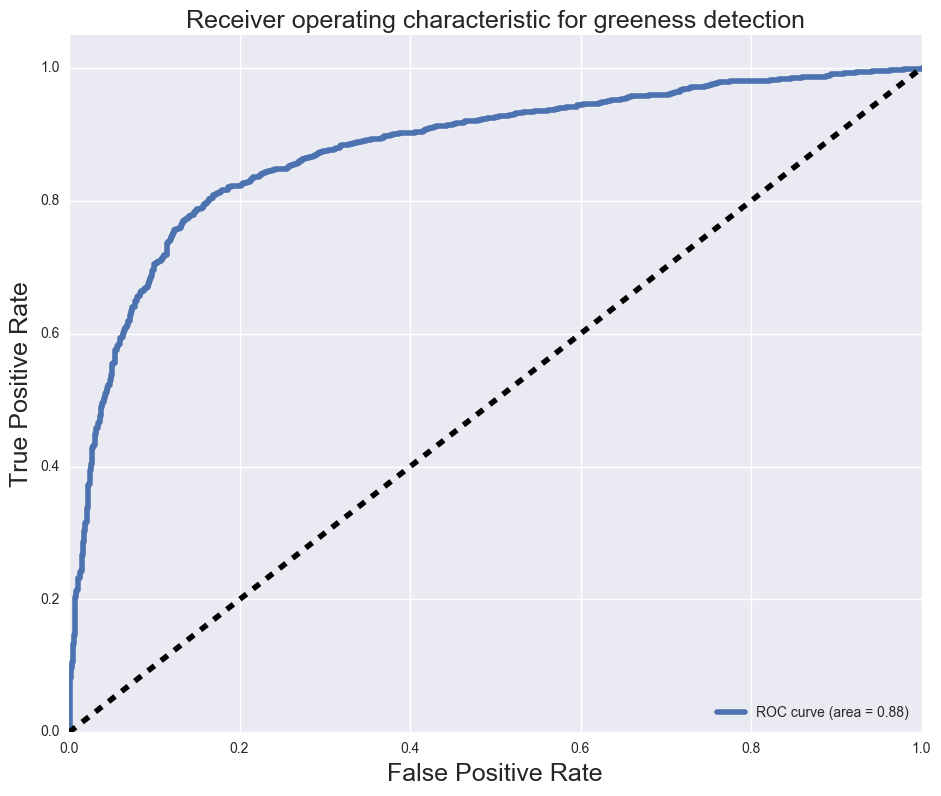

In [16]:
FPR, TPR, thresholds = roc_curve(y_test, Y_proba_score[:,1])

ROC_AUC = auc(FPR, TPR)

plt.figure(figsize=[11,9])
plt.plot(FPR, TPR, label='ROC curve (area = %0.2f)' % ROC_AUC, linewidth=4)
plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('Receiver operating characteristic for greeness detection', fontsize=18)
plt.legend(loc="lower right")
plt.show()